**List 6** - Algorithms and Data Structures 2021/22, WUST - F13

*Author:* Mateusz Machaj, 262288

*Date:* 10.01.2022

# Import

In [88]:
from __future__ import annotations

import time
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

-----------------------

# Task 1

_**Binary search tree class implementation**_

-----------------------

Implementation is written basing on the professor's lecture notes [[1]](#ref1), but some elements are modified - especially handling duplicate keys and issues regarding PEP rules. There were also a couple of mistakes to correct.

I do not use unncessary `get` and `set` methods for attributes, because the code is written with respect to *python* conventions.

## Node class

At first I create a node class representing each unit in binary tree. 

In [21]:
class TreeNode:
    def __init__(
        self,
        key: int,
        value: Any = None,
        parent: TreeNode = None,
        left_ch: TreeNode = None,
        right_ch: TreeNode = None,
    ):
        self.key = key
        self.value = value
        self.parent = parent
        self.left_ch = left_ch
        self.right_ch = right_ch

        self.balance_fact = 0  # used only for AVL Tree

    def is_root(self):
        return not self.parent

    def is_left_ch(self):
        return self.parent and self.parent.left_ch is self

    def is_right_ch(self):
        return self.parent and self.parent.right_ch is self

    def has_left_ch(self):
        return self.left_ch

    def has_right_ch(self):
        return self.right_ch

    def children_number(self):
        if self.left_ch and self.right_ch:
            return 2
        elif not (self.left_ch or self.right_ch):
            return 0
        else:
            return 1

    def is_leaf(self):
        return not bool(self.children_number())

    def get_item_data(self):
        return self.key, self.value

    def set_item_data(self, key: int, value: Any = None):
        self.key = key
        self.value = value

    def get_children(self):
        return self.left_ch, self.right_ch

    def set_children(self, left_ch: TreeNode = None, right_ch: TreeNode = None):
        if left_ch:
            self.left_ch = left_ch
            self.left_ch.parent = self
        if right_ch:
            self.right_ch = right_ch
            self.right_ch.parent = self

## Main tree class

Now, the main binary search tree class.

I assume that **repeated keys are not allowed** [[2]](#ref2). It means that left children are strictly smaller and right - strictly greater (unlike in the lecture notes).

In [75]:
class BSTree:
    def __init__(self):
        self.root = None
        self.size = 0

    def length(self):
        return self.size

    def __len__(self):
        return self.size

    def _put(self, key: int, value: Any, current_node: TreeNode):
        if key < current_node.key:
            if current_node.has_left_ch():
                self._put(key, value, current_node.left_ch)
            else:
                current_node.left_ch = TreeNode(key, value, parent=current_node)
        elif key > current_node.key:
            if current_node.has_right_ch():
                self._put(key, value, current_node.right_ch)
            else:
                current_node.right_ch = TreeNode(key, value, parent=current_node)
        elif key == current_node.key:
            current_node.value = value

    def put(self, key: int, value: Any = None):
        if self.root:
            self._put(key, value, self.root)
        else:
            self.root = TreeNode(key, value)
        self.size += 1

    def __setitem__(self, key: int, value: Any):
        self.put(key, value)

    def _get(self, key: int, current_node: TreeNode = None):
        if not current_node:
            current_node = self.root
        if key < current_node.key:
            if current_node.has_left_ch():
                return self._get(key, current_node.left_ch)
            else:
                return None
        elif key > current_node.key:
            if current_node.has_right_ch():
                return self._get(key, current_node.right_ch)
            else:
                return None
        elif key == current_node.key:
            return current_node

    def get(self, key: int):
        if self.root:
            search_res = self._get(key, self.root)
            if search_res:
                return search_res.value
            else:
                return None
        else:
            return None

    def __getitem__(self, key: int):
        return self.get(key)

    def __contains__(self, key: int):
        if self._get(key, self.root):
            return True
        else:
            return False

    def _find_min(self, current_node: TreeNode = None):
        if not current_node:
            current_node = self.root
        while current_node.has_left_ch():
            current_node = current_node.left_ch
        return current_node

    def first_item(self):
        min_key_node = _find_min()
        return (min_key_node.key, min_key_node.value)

    def _find_max(self, current_node: TreeNode = None):
        if not current_node:
            current_node = self.root
        while current_node.has_right_ch():
            current_node = current_node.right_ch
        return current_node

    def last_item(self):
        max_key_node = _find_max()
        return (max_key_node.key, max_key_node.value)

    def _find_successor(self, current_node: TreeNode = None):
        if not current_node:
            current_node = self.root
        succ = None
        if current_node.has_right_ch():
            succ = self._find_min(current_node.right_ch)
        else:
            if not current_node.is_root():
                if current_node.is_left_ch():
                    succ = current_node.parent
                else:
                    current_node.parent.right_ch = None
                    succ = self._find_successor(current_node.parent)
                    current_node.parent.right_ch = current_node
        return succ

    def _remove(self, current_node: TreeNode):
        if current_node.is_leaf():
            if current_node.is_left_ch():
                current_node.parent.left_ch = None
            else:
                current_node.parent.right_ch = None
        elif current_node.children_number() == 2:
            succ = self._find_successor(current_node)
            if not succ:
                raise Exception("Successor searching error.")
            current_node.set_item_data(*succ.get_item_data())
            self._remove(succ)

        else:
            if current_node.has_left_ch():
                child = current_node.left_ch
            else:
                child = current_node.right_ch
            if current_node.is_left_ch():
                current_node.parent.set_children(child, None)
            elif current_node.is_right_ch():
                current_node.parent.set_children(None, child)
            else:
                current_node.set_item_data(*child.get_item_data())
                current_node.set_children(*child.get_children())

    def delete(self, key: int):
        if self.size > 1:
            current_node = self._get(key)
            if current_node:
                self._remove(current_node)
                self.size -= 1
            else:
                raise KeyError("Key not foundA.")

        # condition not nec? but then change the first to geq
        elif self.size == 1 and self.root.key == key:
            self.root = None
            self.size -= 1
        else:
            raise KeyError("Key not found.")

    def __delitem__(self, key: int):
        self.delete(key)

While using the class only with the methods provided there are no issues with double keys. Changing any values manually causes many problems and creates ambiguous situation in key set. I do not handle this for obvious reasons. In other languages external inaccessibility of attributes solves it. In *python* we assume reasonable usage.

## AVG Tree

Having the basic binary search tree class, we can also implement AVL tree - as it is done in notes [[1]](#ref1), so by inheritance. This is going to be our final product.

In [25]:
class AVLTree(BSTree):
    def rotate_left(self, rot_root: TreeNode):
        pass

    def rotate_right(self, rot_root: TreeNode):
        pass

    def rebalance(self, current_node: TreeNode):
        pass

    def update_balance(self, current_node: TreeNode):
        if abs(current_node.balance_fact) > 1:
            self.rebalance(current_node)
            return
        if not current_node.is_root():
            if current_node.is_left_ch():
                current_node.parent.balance_fact += 1
            else:
                current_node.parent.balance_fact -= 1
            if current_node.parent.balance_fact != 0:
                self.update_balance(current_node.parent)

    def _put(self, key: int, value: Any, current_node: TreeNode):
        if key < current_node.key:
            if current_node.has_left_ch():
                self._put(key, value, current_node.left_ch)
            else:
                current_node.left_ch = TreeNode(key, value, parent=current_node)
                self.update_balance(current_node.left_ch)
        elif key > current_node.key:
            if current_node.has_right_ch():
                self._put(key, value, current_node.right_ch)
            else:
                current_node.right_ch = TreeNode(key, value, parent=current_node)
                self.update_balance(current_node.right_ch)
        elif key == current_node.key:
            current_node.value = value

## Presentation

In [74]:
bst1 = BSTree()
bst1[5] = 0
bst1[6] = 0
bst1[9] = 0
bst1[7] = 0
bst1[10] = 0

bst1.delete(9)

right
right


In [76]:
bst = BSTree()
bst[10] = 0
bst[5] = 0
bst[7] = 0
bst[1] = 0
bst[9] = 0
bst[21] = 0
bst[2] = 0
bst[9]

# print(bst._get(5, bst.root))
bst.delete(5)
# bst._find_successor(bst._get(5)).key

-----------------------

# Task 2

_**Sorting algorithm with binary heap**_

-----------------------

## Main class

Binary heap class will be writen also according to the professor's lecture notes [[3]](#ref3), using *python* lists in implementation - that is simply convenient.

However, in contrary to the sample shown, the *root* is identified with the **maximal** number.

In [78]:
class BinHeap:
    def __init__(self):
        self.heap_list = [0]
        self.size = 0

    def get_parent(self, index: int):
        return index // 2

    def get_left_ch(self, index: int):
        return index * 2

    def get_right_ch(self, index: int):
        return index * 2 + 1

    def _perc_up(self, index: int):
        parent = self.get_parent(index)
        while parent > 0:

            if self.heap_list[index] > self.heap_list[parent]:
                self.heap_list[parent], self.heap_list[index] = (
                    self.heap_list[index],
                    self.heap_list[parent],
                )
            index = self.get_parent(index)
            parent = self.get_parent(index)

    def insert(self, value: float):
        self.heap_list.append(value)
        self.size += 1
        self._perc_up(self.size)

    def find_max(self):
        return self.heap_list[1]

    def _max_child(self, index: int):
        left_ch = self.get_left_ch(index)
        right_ch = self.get_right_ch(index)
        if left_ch > self.size:
            return None
        elif left_ch == self.size:
            return left_ch
        else:
            if self.heap_list[left_ch] > self.heap_list[right_ch]:
                return left_ch
            else:
                return right_ch

    def _perc_down(self, index: int):
        while self.get_left_ch(index) <= self.size:
            max_ch = self._max_child(index)
            if self.heap_list[index] < self.heap_list[max_ch]:
                self.heap_list[index], self.heap_list[max_ch] = (
                    self.heap_list[max_ch],
                    self.heap_list[index],
                )
            index = max_ch

    def pop_max(self):
        return_value = self.heap_list[1]
        self.heap_list[1] = self.heap_list[self.size]
        self.heap_list.pop()
        self.size -= 1
        self._perc_down(1)
        return return_value

    def build_heap(self, alist: list):
        if not all(isinstance(elem, float) or isinstance(elem, int) for elem in alist):
            raise TypeError("List should contain only numbers.")
        self.size = len(alist)
        self.heap_list = [0] + alist[:]
        index = self.size // 2
        while index > 0:
            self._perc_down(index)
            index -= 1

    def get_size(self):
        return self.size

    def __len__(self):
        return self.get_size()

    def is_empty(self):
        return self.size == 0

    def __str__(self):
        txt = "{}".format(self.heap_list[1:])
        return txt

## Sorting

Now, using the binary heap I can write a function which **sorts the numbers in descending order**. To gain the opposite effect we should have created a *Min-Heap* instead of *Max-Heap*, but this was an aim specified on the lesson.

In [160]:
def sort_list(alist: list):
    bin_heap = BinHeap()
    bin_heap.build_heap(alist)
    sorted_alist = []
    while not bin_heap.is_empty():
        sorted_alist.append(bin_heap.pop_max())
    return sorted_alist

## Complexity analysis

### Measurment tools

First step of analysis is to create a list of random numbers. I will use `np.random.random`.

Next, we have got a function measuring `sort_list` performace time. This is actually almost <u>copied</u> from my previous list [[4]](#ref4) (as well as the other following functions).

In [161]:
def time_check(size: int) -> float:
    """Chceck the performance time for `sort_list` function and given list size.

    Args:
        size (int): List length.

    Returns:
        float: Time of the operation.
    """
    alist = list(np.random.random(size))

    time_a = time.time()
    sort_list(alist)
    time_b = time.time()
    time_diff = time_b - time_a
    return time_diff

Finally a data collecting function, calling `sort_time` in loop for different sizes.

In [162]:
def collect_data(size: int, step: int) -> tuple:
    """Examine the function `sort_list` and find the calculation times for a range of sizes.

    Args:
        size (int): List length.
        step (int): Interval between sizes in tested calls.

    Returns:
        tuple: Performance data: (List lengths, Times for each size).
    """
    time_reg = []
    rng = range(1, size + 1, step)

    for N in rng:
        time_reg.append(time_check(N))

    return (rng, time_reg)

### Visualisation tools

Following function can plot graphs of the data and additionally - another "hypothetic" function.

In [163]:
def plot_data(
    x_vals: range, y_vals: list, yscale: str = "linear", function: function = None
):
    """Plot the performance data and optionally the hypothetic function that `solve` converges to in terms of time complexity.

    Args:
        x_vals (range): List sizes.
        y_vals (list): Performance times for lists.
        yscale (str, optional): Scale on Y axis. Defaults to "linear".
        function (function, optional): Hypothetic function to layer its plot with the data. Defaults to None.
    """
    plt.plot(x_vals, y_vals, "o")
    if function != None:
        f_y_vals = function(x_vals)
        plt.plot(x_vals, f_y_vals)

    plt.yscale(yscale)
    plt.xlabel("List length")
    plt.ylabel("Time")
    plt.title("Sorting function performance")
    plt.gca().legend(("Collected data", "Hypothesis"))
    plt.show()

### Data collecting

For some reasonable size and steps I collect data from function's performace.

In [171]:
size = 30000
step = 1500
data = collect_data(size, step)

### Hypothesis and its visualization

My first hypothesis would be based on the task and algorithm analysis - I assume that `sort_list` has $O(n \log(n))$ time complexity.

I use optimalization fitting tools and define new `f_fit` function as a hypothesis.

In [172]:
def func(x: float, a: float, c: float) -> float:
    """Create a cubic polynomial.

    Args:
        x (float): Independent variable.
        a (float): Multiplication factor.
        c (float): Added constant.

    Returns:
        float: Value of `n*log(n)` in some point x.
    """
    return a * x * np.log2(x) + c

In [173]:
popt, pcov = curve_fit(func, list(data[0]), data[1])
print(popt)

[9.03424706e-07 1.29320076e-02]


In [174]:
def f_fit(x: float) -> float:
    """Create a `n*log(n)` function with appropriate coefficients.

    Args:
        x (float): Independent variable.

    Returns:
        float: Function with optimal numbers set as coefficients.
    """
    return func(x, *popt)

For the fitted $A$ and $C$ values in $f(n) = A n \log(n) + C$ the comparison is presented in the graph.

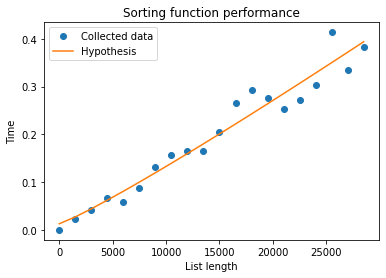

In [175]:
plot_data(*data, function=f_fit)

It seems that hypothesis was **correct**. We see a satisfying curve fit for this function.

### Prediction

Let us try predictions for sizes $n_1=30000$ and $n_2=32000$.

In [176]:
n1 = int(1e5)
n2 = int(2e5)

For $f(n_1)$:

In [177]:
f_fit(n1)

1.513487963885513

And for $f(n_2)$:

In [178]:
f_fit(n2)

3.194728861414619

### Verification

Now, we have got measured times for real `sort_list` algorithm:

In [179]:
time_check(n1)

1.7566165924072266

In [180]:
time_check(n2)

3.5521624088287354

Viewing the results on my device I can claim that they actulally fit very well.

### Results

We clearly see that for greater values the assumption is good.

So, `sort_list` has **$O(n \log(n))$ time complexity** indeed.

## Presentation

In [82]:
bh = BinHeap()
bh.insert(5)
bh.insert(10)
bh.insert(1)
bh.insert(320)
bh.insert(1)
bh.insert(3)
bh.insert(18)
bh.insert(19)


print(bh)

[320, 19, 18, 10, 1, 1, 3, 5]


In [81]:
sort_list([10, 2, 50, 4, 10, 44])

[50, 44, 10, 10, 4, 2]

-----------------------

# Task 3

_**Binary heap with a limited size**_

-----------------------

This time I use *Max-Heap* again. Not to repeat the same code, I create a inheriting class and adjust necessary things.

-----------------------

# References

<a id="ref1">[1]</a> J. Szwabiński, *Wykład 9 - Drzewa i algorytmy ich przetwarzania (ciąg dalszy)*,  *Algorytmy i struktury danych*, p. 2-16. [accessed: 08.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/9.pdf.

<a id="ref2">[2]</a> M. Hofri; H. Mahmoud, *Algorithmics of Nonuniformity: Tools and Paradigms*, 2019, p. 261.

<a id="ref3">[3]</a> J. Szwabiński, *Wykład 8 - Drzewa i algorytmy ich przetwarzania*,  *Algorytmy i struktury danych*, p. 17-24. [accessed: 08.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/9.pdf.

<a id="ref4">[4]</a> File *"lista5_machaj.ipynb"* was sent as a task via email. It <u>might</u> be also posted on my *GitHub*. Link: https://github.com/o-mateo-o.